In [2]:
import numpy as np
import pandas as pd
import os
import glob
from scipy import stats

In [13]:
cd ..\..\notebooks

E:\proj\senofag\notebooks


In [197]:
import superskrypt as s

In [3]:
PTH = r"E:\proj\senofag\data\data current"

E:\proj\senofag\data\data current


In [79]:
color_map = s.all_colors(df)
color_map[3]

{'b': 'incomp_r',
 'g': 'incomp_l',
 'o': 'neut_l',
 'p': 'comp_r',
 'r': 'comp_l',
 'y': 'neut_r'}

In [6]:
fls = glob.glob('*.txt')
fls[:3]

['s1.txt', 's11.txt', 's13.txt']

In [8]:
df = pd.read_csv(os.path.join(PTH, fls[4]), sep='\t')
df.columns

Index(['ExperimentName', 'Subject', 'Session', 'Age', 'Clock.Information',
       'DataFile.Basename', 'Display.RefreshRate', 'ExperimentVersion',
       'Group', 'Name',
       ...
       'TrialList1', 'TrialList1.Cycle', 'TrialList1.Sample', 'TrialList2',
       'TrialList2.Cycle', 'TrialList2.Sample', 'TrialType', 'TrPosit',
       'TrWaitTime', 'WaitTime'],
      dtype='object', length=156)

In [80]:
# clean up df
def clean_dataframe(df):
    select_columns = ['Subject', 'Block', 'Effect', 'Prime', 'Target', 'TargetSlide.RESP', 'TargetSlide.ACC',
                      'TrialType', 'TargetSlide.RT']
    trials_df = df.loc[:, select_columns].query('Block > 1 & Effect == Effect')

    # rename columns
    new_cols = [x.lower() for x in trials_df.columns.tolist()[:5]]
    trials_df.columns = new_cols + ['resp', 'acc', 'condition', 'RT']

    # clean up Effect, Prime and Target
    trials_df.effect = trials_df.effect.str.replace('color_', '').str.replace('.png', '')
    trials_df.prime = trials_df.prime.str.replace('prime_', '').str.replace('.png', '')
    trials_df.target = trials_df.target.str.replace('target_', '').str.replace('.png', '')

    # responses: l is right, d id left
    trials_df.resp = trials_df.resp.str.replace('l', 'right').str.replace('d', 'left')

    # acc is of type int
    trials_df.acc = trials_df.acc.astype('int')

    # new column order
    col_ord = trials_df.columns.tolist()
    col_ord.remove('condition')
    col_ord.insert(2, 'condition')

    trials_df = trials_df.reset_index(drop=True).loc[:, col_ord]
    return trials_df

trials_df = clean_dataframe(df)
trials_df.head()

,subject,block,condition,effect,prime,target,resp,acc,RT
0,18,3,comp,purple,right,right,right,1,302.0
1,18,3,incomp,purple,right,both,right,0,614.0
2,18,3,neut,yellow,left,right,right,1,463.0
3,18,3,comp,red,left,both,left,0,593.0
4,18,3,neut,orange,right,left,left,1,459.0


In [54]:
import seaborn as sns
%matplotlib inline

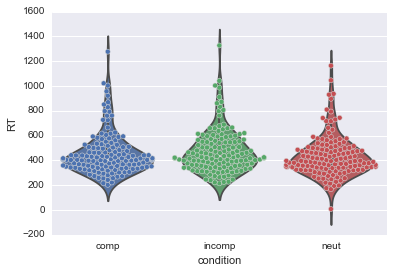

In [72]:
sns.violinplot('condition', 'RT', data=trials_df)
sns.swarmplot('condition', 'RT', data=trials_df, edgecolor=[0.85] * 3, lw=0.5)

In [66]:
# jak często osoba "przezwycięża" prymę w warunku wolnym:
df_both = trials_df.query('target == "both"')
df_both.pivot_table(index='prime', columns='resp', aggfunc='count').RT

resp,left,right
prime,,
left,53,57
right,50,56


In [67]:
trials_df.loc[:, 'resp_comp'] = trials_df.prime == trials_df.resp
df_both.groupby('resp_comp').RT.mean()

resp_comp
False    493.551402
True     487.532110
Name: RT, dtype: float64

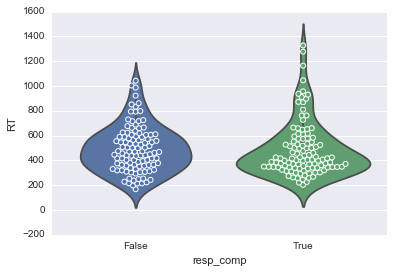

In [74]:
sns.violinplot('resp_comp', 'RT', data=df_both)
sns.swarmplot('resp_comp', 'RT', data=df_both, edgecolor='w', lw=1)

E:\prog\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


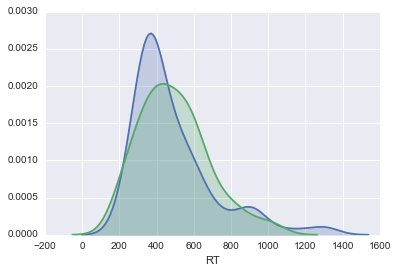

In [76]:
sns.distplot(df_both.query('resp_comp == True').RT, hist=False, kde_kws=dict(shade=True))
sns.distplot(df_both.query('resp_comp == False').RT, hist=False, kde_kws=dict(shade=True))

In [78]:
from scipy.stats import trim_mean
rt_comp = [trim_mean(df_both.query('resp_comp == {}'.format(cnd)).RT, 0.2)
           for cnd in ['True', 'False']]
rt_comp

[434.08955223880599, 475.80000000000001]

In [92]:
index = [int(x.split('.')[0][1:]) for x in fls]
full_df = pd.DataFrame(index=index, columns=['condition', 'prime_compatible', 'incomp_cost_ms', 'incomp_cost_perc'],
                       dtype='float')
full_df.head()

,condition,prime_compatible,incomp_cost_ms,incomp_cost_perc
1,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN


In [85]:
from tqdm import tqdm_notebook

In [93]:
for f in tqdm_notebook(fls):
    subject_id = int(f.split('.')[0][1:])
    df = pd.read_csv(os.path.join(PTH, f), sep='\t')
    df = clean_dataframe(df)
    df_both = df.query('target == "both"')
    df_both.loc[:, 'resp_comp'] = df_both.prime == df_both.resp
    
    full_df.loc[subject_id, 'condition'] = ['noinfo', 'info'][(subject_id % 2) == 0]
    full_df.loc[subject_id, 'prime_compatible'] = df_both.resp_comp.mean()
    
    rt_comp = [trim_mean(df_both.query('resp_comp == {}'.format(cnd)).RT, 0.2)
               for cnd in ['True', 'False']]
    full_df.loc[subject_id, 'incomp_cost_ms'] = rt_comp[1] - rt_comp[0]
    full_df.loc[subject_id, 'incomp_cost_perc'] = rt_comp[1] / rt_comp[0]

E:\prog\Anaconda\lib\site-packages\pandas\core\indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
E:\prog\Anaconda\lib\site-packages\pandas\core\indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [94]:
full_df.head()

,condition,prime_compatible,incomp_cost_ms,incomp_cost_perc
1,noinfo,0.486111,12.623312,1.039720
11,noinfo,0.560185,8.516703,1.025850
13,noinfo,0.562791,18.975437,1.054303
15,noinfo,0.476852,0.036577,1.000100
18,info,0.504630,41.710448,1.096087


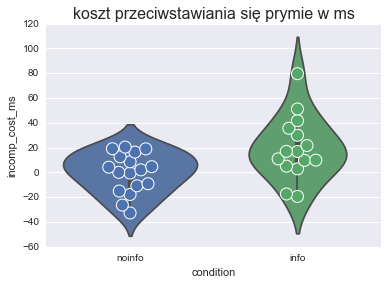

In [129]:
sns.violinplot('condition', 'incomp_cost_ms', data=full_df)
fig = sns.swarmplot('condition', 'incomp_cost_ms', data=full_df, edgecolor='w', lw=1, size=12)

fig.set_title('koszt przeciwstawiania się prymie w ms', fontsize=16)

In [119]:
from scipy.stats import pearsonr, ttest_ind, levene
from mypy.stats import format_pvalue

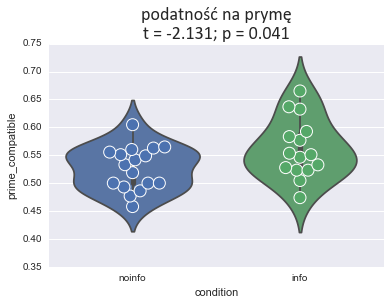

In [127]:
test = ttest_ind(full_df.query('condition == "noinfo"').prime_compatible,
                 full_df.query('condition == "info"').prime_compatible)

text = 'podatność na prymę'
text += '\n' + 't = {:.3f}; {}'.format(test.statistic, format_pvalue(test.pvalue))

sns.violinplot('condition', 'prime_compatible', data=full_df)
fig = sns.swarmplot('condition', 'prime_compatible', data=full_df, edgecolor='w', lw=1, size=12)
fig.set_title(text, fontsize=18, fontname='calibri')

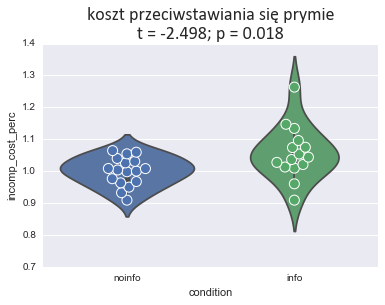

In [132]:
test = ttest_ind(full_df.query('condition == "noinfo"').incomp_cost_perc,
                 full_df.query('condition == "info"').incomp_cost_perc)

text = 'koszt przeciwstawiania się prymie'
text += '\n' + 't = {:.3f}; {}'.format(test.statistic, format_pvalue(test.pvalue))

sns.violinplot('condition', 'incomp_cost_perc', data=full_df)
fig = sns.swarmplot('condition', 'incomp_cost_perc', data=full_df, edgecolor='w', lw=1, size=10)
fig.set_title(text, fontsize=18, fontname='calibri')

sns.plt.savefig('prime_cost_prop_vs_info.png', dpi=350)

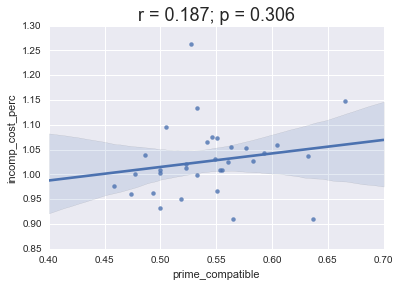

In [120]:
r, pvalue = pearsonr(full_df['prime_compatible'], full_df['incomp_cost_perc'])
text = 'r = {:.3f}; {}'.format(r, format_pvalue(pvalue))

fig = sns.regplot('prime_compatible', 'incomp_cost_perc', data=full_df)
fig.set_title(text, fontsize=18)

In [110]:
r, pvalue = pearsonr(full_df['prime_compatible'], full_df['incomp_cost_perc'])
print('r = {:.3f}, {}'.format(r, format_pvalue(pvalue)))

r = 0.187, p = 0.306


In [114]:
test = ttest_ind(full_df.query('condition == "noinfo"').incomp_cost_perc,
                 full_df.query('condition == "info"').incomp_cost_perc)

print('t = {:.3f}, {}'.format(test.statistic, format_pvalue(test.pvalue)))

t = -2.498, p = 0.018


In [118]:
test = levene(full_df.query('condition == "noinfo"').incomp_cost_perc,
                 full_df.query('condition == "info"').incomp_cost_perc)

print('levene = {:.3f}, {}'.format(test.statistic, format_pvalue(test.pvalue)))

levene = 2.025, p = 0.165


## Wczytujemy zagregowane dane
W zagregowanych danych mamy oszacowane poczucie sprawstwa

In [136]:
agg_df = pd.read_excel(r'F:\DANE\BAZA_MIXED_MODELS.xlsx')
agg_df = agg_df.rename(columns={'info_noinfo': 'group',
                                'comp_incomp': 'condition'})
agg_df.head()

,subj_nr,group,SoA,condition,RT
0,1,info,18.416667,comp,342.664141
1,1,info,16.666667,neut,335.536508
2,1,info,17.416667,incomp,358.725222
3,2,noinfo,80.916667,comp,401.137055
4,2,noinfo,80.250000,neut,414.798500


E:\prog\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


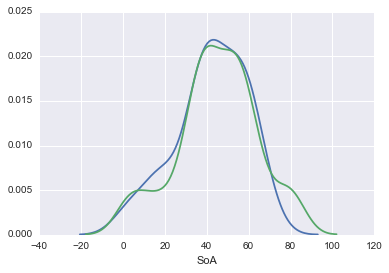

In [138]:
sns.distplot(agg_df.query('group == "info"').SoA, hist=False)
sns.distplot(agg_df.query('group == "noinfo"').SoA, hist=False)

In [157]:
for s in np.unique(agg_df.subj_nr):
    subj_df = agg_df.query('subj_nr == {}'.format(s))
    SoA = subj_df.SoA / subj_df.query('condition == "neut"').SoA.values
    SoA.index = subj_df.condition
    
    full_df.loc[s, 'SoA_comp'] = SoA['comp']
    full_df.loc[s, 'SoA_incomp'] = SoA['incomp']

full_df.loc[:, 'SoA_diff'] = full_df.loc[:, 'SoA_comp'] - full_df.loc[:, 'SoA_incomp']

In [158]:
full_df.head()

,condition,prime_compatible,incomp_cost_ms,incomp_cost_perc,SoA_comp,SoA_incomp,SoA_diff
1,noinfo,0.486111,12.623312,1.039720,1.105000,1.045000,0.060000
11,noinfo,0.560185,8.516703,1.025850,1.026163,0.882267,0.143895
13,noinfo,0.562791,18.975437,1.054303,0.855967,0.884774,-0.028807
15,noinfo,0.476852,0.036577,1.000100,0.715308,0.662375,0.052933
18,info,0.504630,41.710448,1.096087,1.056433,1.623025,-0.566591


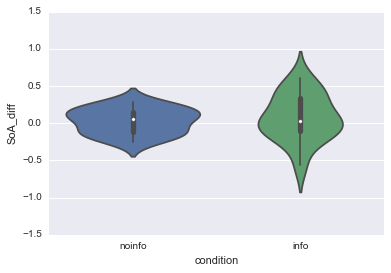

In [161]:
sns.violinplot('condition', 'SoA_diff', data=full_df)

In [163]:
levene(full_df.query('condition == "info"').SoA_diff,
       full_df.query('condition == "noinfo"').SoA_diff)

LeveneResult(statistic=3.1458192846890531, pvalue=0.086274272400648347)

E:\prog\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


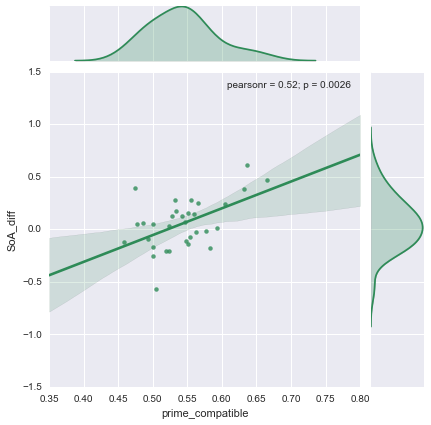

In [172]:
sns.jointplot('prime_compatible', 'SoA_diff', data=full_df,
              marginal_kws=dict(hist=False, kde=True, kde_kws=dict(shade=True)),
              color='seagreen', kind='reg')

E:\prog\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


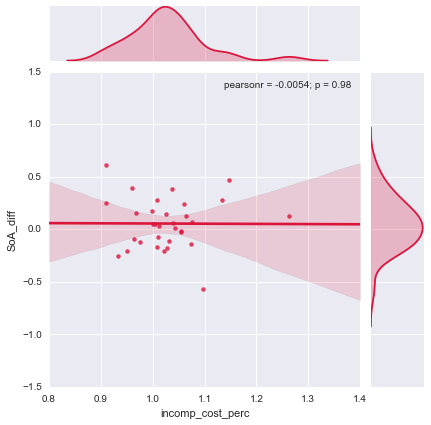

In [179]:
sns.jointplot('incomp_cost_perc', 'SoA_diff', data=full_df,
              marginal_kws=dict(hist=False, kde=True, kde_kws=dict(shade=True)),
              color='crimson', kind='reg')

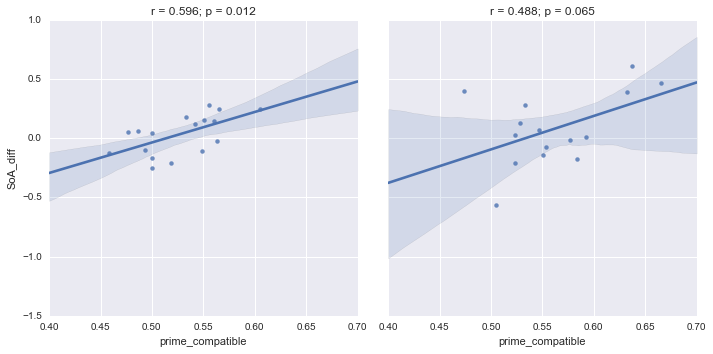

In [273]:
fig = sns.lmplot('prime_compatible', 'SoA_diff', data=full_df, col='condition')
axes = fig.axes

for cond, ax in zip(['noinfo', 'info'], axes.ravel()):
    this_df = full_df.query('condition == "{}"'.format(cond))
    r, pvalue = pearsonr(this_df.prime_compatible, this_df.SoA_diff)
    ax.set_title('r = {:.3f}; {}'.format(r, format_pvalue(pvalue)))

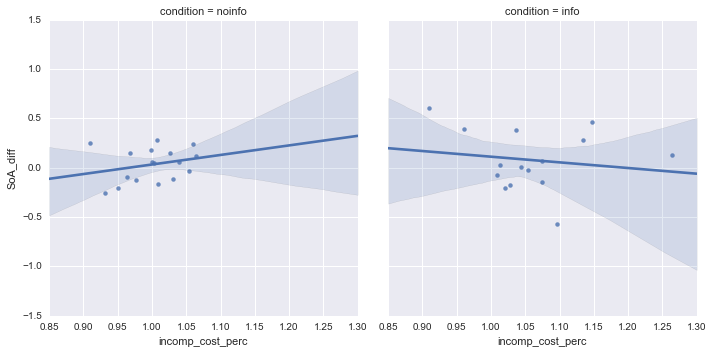

In [224]:
sns.lmplot('incomp_cost_perc', 'SoA_diff', data=full_df, col='condition')

<img src="https://ligaswiatowa.files.wordpress.com/2015/01/bnm1.jpg">

<img src="http://img1.demotywatoryfb.pl//uploads/201603/1458133055_q1lxqv_600.jpg"/>

## Testy rozbicia bronią magnetyczną

In [193]:
trials_df.pivot_table(values='RT', index='block', columns='target', aggfunc='count')

target,both,left,right
block,,,
3,18,26,27
4,54,9,9
5,54,9,9
6,18,25,27
7,18,27,27
8,54,9,8


In [274]:
df = pd.read_csv(os.path.join(PTH, fls[4]), sep='\t')

In [199]:
color_map = s.all_colors(df)
color_map[3]

{'b': 'incomp_r',
 'g': 'incomp_l',
 'o': 'neut_l',
 'p': 'comp_r',
 'r': 'comp_l',
 'y': 'neut_r'}

In [200]:
sorted_colors, colors_soa = s.get_sorted_colors(df, blocknum=3)

In [201]:
sorted_colors

['y', 'o', 'p', 'r', 'g', 'b']

In [202]:
colors_soa

array([15, 23, 36, 50, 75, 95])

In [205]:
block = 3
block_soa = {v.split('_')[0]: list() for v in color_map[block].values()}
block_soa

{'comp': [], 'incomp': [], 'neut': []}

In [206]:
for k, v in color_map[block].items():
    cond = v.split('_')[0]
    color_order = sorted_colors.index(k)
    block_soa[cond].append(colors_soa[color_order])

In [207]:
block_soa

{'comp': [50, 36], 'incomp': [75, 95], 'neut': [15, 23]}

In [208]:
block_soa = {k : np.mean(v) for k, v in block_soa.items()}
block_soa

{'comp': 43.0, 'incomp': 85.0, 'neut': 19.0}

In [236]:
both_by_block = trials_df.pivot_table(values='RT', index='block', columns='target', aggfunc='count')
both_block = both_by_block.both > 30

byblock_df = pd.DataFrame(index=range(3, 9), columns=['both', 'comp', 'incomp', 'neut'],
                          dtype='float')
byblock_df.loc[:, 'both'] = both_block

for block in range(3, 9):
    sorted_colors, colors_soa = s.get_sorted_colors(df, blocknum=block)
    block_soa = {v.split('_')[0]: list() for v in color_map[block].values()}

    for k, v in color_map[block].items():
        cond = v.split('_')[0]
        color_order = sorted_colors.index(k)
        block_soa[cond].append(colors_soa[color_order])

    block_soa = {k : np.mean(v) for k, v in block_soa.items()}

    for k, v in block_soa.items():
        byblock_df.loc[block, k] = v

In [237]:
byblock_df

,both,comp,incomp,neut
3,False,43.0,85.0,19.0
4,True,32.5,42.5,67.5
5,True,16.0,74.5,35.0
6,False,45.0,60.0,2.5
7,False,50.0,57.5,22.5
8,True,47.5,40.0,75.0


In [232]:
from itertools import product

blabla = byblock_df.groupby('both').mean()
colnames = ['_'.join([s2, s1]) for s1, s2 in product(['cued', 'free'], blabla.columns)]
colnames

['comp_cued',
 'incomp_cued',
 'neut_cued',
 'comp_free',
 'incomp_free',
 'neut_free']

In [231]:
blabla

,comp,incomp,neut
both,,,
False,53.5,62.333333,31.166667
True,44.5,35.666667,66.833333


In [233]:
blabla.values.ravel()

array([ 53.5       ,  62.33333333,  31.16666667,  44.5       ,
        35.66666667,  66.83333333])

In [235]:
soa_effects = pd.DataFrame(index=full_df.index, columns=colnames, dtype='float')

In [240]:
for f in tqdm_notebook(fls):
    # load df
    subj = int(f.split('.')[0][1:])
    df_orig = pd.read_csv(os.path.join(PTH, f), sep='\t')
    df = clean_dataframe(df_orig)
    
    color_map = s.all_colors(df_orig)

    both_by_block = df.pivot_table(values='RT', index='block', columns='target', aggfunc='count')
    both_block = both_by_block.both > 30

    byblock_df = pd.DataFrame(index=range(3, 9), columns=['both', 'comp', 'incomp', 'neut'],
                              dtype='float')
    byblock_df.loc[:, 'both'] = both_block

    for block in range(3, 9):
        sorted_colors, colors_soa = s.get_sorted_colors(df_orig, blocknum=block)
        block_soa = {v.split('_')[0]: list() for v in color_map[block].values()}

        for k, v in color_map[block].items():
            cond = v.split('_')[0]
            color_order = sorted_colors.index(k)
            block_soa[cond].append(colors_soa[color_order])

        block_soa = {k : np.mean(v) for k, v in block_soa.items()}

        for k, v in block_soa.items():
            byblock_df.loc[block, k] = v
        
        soa_effects.loc[subj, :] = byblock_df.groupby('both').mean().values.ravel()

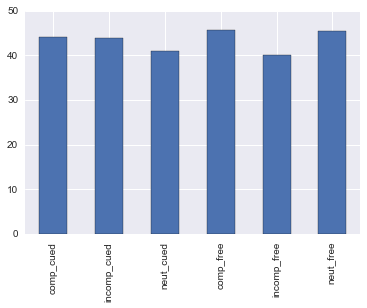

In [243]:
soa_effects.mean().plot(kind='bar')

In [265]:
soa_effects_cued = pd.DataFrame(index=soa_effects.index, columns=['comp', 'incomp'],
                                dtype='float')

for i, row in soa_effects.iloc[:, :3].iterrows():
    soa_effects_cued.loc[i, 'comp'] = row.comp_cued / row.neut_cued
    soa_effects_cued.loc[i, 'incomp'] = row.incomp_cued / row.neut_cued

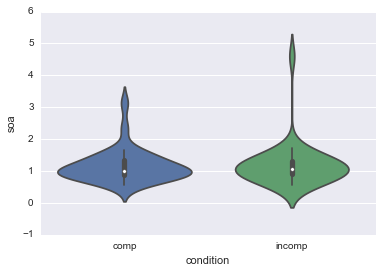

In [266]:
soa_effects_cued = pd.melt(soa_effects_cued, var_name='condition', value_name='soa')
sns.violinplot('condition', 'soa', data=soa_effects_cued)

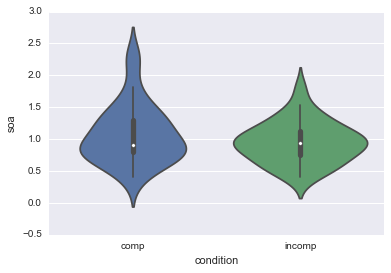

In [268]:
soa_effects_free = pd.DataFrame(index=soa_effects.index, columns=['comp', 'incomp'],
                                dtype='float')

for i, row in soa_effects.iterrows():
    soa_effects_free.loc[i, 'comp'] = row.comp_free / row.neut_free
    soa_effects_free.loc[i, 'incomp'] = row.incomp_free / row.neut_free
    
soa_effects_free = pd.melt(soa_effects_free, var_name='condition', value_name='soa')
sns.violinplot('condition', 'soa', data=soa_effects_free)